In [1]:
%matplotlib inline
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from createData import createSingleChi

In [2]:
# dataset = h5py.File("data/dataset32AugV1.hdf5", 'r')
dataset = h5py.File("data/dataset32AugV2.hdf5", 'r')
# dataset = h5py.File("data/dataset32AugV2test.hdf5", 'r')
# dataset = h5py.File("data/dataset32AugV3test.hdf5", 'r')
numPoints =  40
# numPoints =  2
numSamples = 10
coh = dataset['coh']
par = dataset['par']
parN = dataset['parNorm']

predictionsFile = "files/configWinCNN2W3/predictions/best-33-all-Ra.npz"
# predictionsFile = "files/configWinCNN2/predictions/best-94-all-Ra.npz"

# windows = [[0+150,201+150], [0+50,201+50], [15+25, 216+25]] # from processRealData.py plus index of first not zero
windows = [[0,201], [0,201], [15, 216]] # from processRealData.py

In [3]:
parN.shape

(25600000, 4)

In [4]:
def plotValues(values=[0, 0, 0, 0], valuesN=[0, 0, 0, 0], var=0, indexes=False, extraPlot=None, extraPlotWindow=None, title=None, save=None, color='C0', labelText='Truth'):
    if len(valuesN) != 4:
        raise Exception("Wrong length")
    if indexes:
        index = valuesN
    else:
        if min(valuesN) < 0 or max(valuesN) > 1:
            raise Exception("Wrong values")
        index = [round(v*(numPoints-1)) for v in valuesN]
    if type(var) is int:
        var = [var]

    fig = plt.figure(figsize=(8,5))
    for v in var:
        calcBase = v + (index[3] + index[2]*numPoints + index[1]*(numPoints**2) + index[0]*(numPoints**3)) * numSamples
        # plt.plot(coh[calcBase], label="[{:.2f}, {:.2f}, {:.2f}, {:.2f}]({})".format(*parN[calcBase],v))
        plt.plot(coh[calcBase], label="[  y0,        a,        B,           W1  ]\n[{:.3f}, {:.3f}, {:.3f}, {:.3f}]({})\n[{:.3f}, {:.3f}, {:.3f}, {:.3f}]({} norm.)\n[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Near)\n[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Near norm.)".format(*values, labelText, *valuesN, labelText, *par[calcBase], *parN[calcBase]), color=color)
    if not extraPlot is None:
        notZero = np.argwhere(extraPlot[0] != 0)
        firstNotZero = notZero[0][0]
        plt.plot(notZero, extraPlot[0][notZero], label="[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Exp.)\n[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Exp. norm.)".format(*extraPlot[1], *extraPlot[2]), color='C1')
        if not extraPlotWindow is None:
            # plt.plot(np.concatenate(notZero[0:extraPlotWindow[0]], notZero[extraPlotWindow[1]:-1]), np.concatenate(extraPlot[0][notZero[0:extraPlotWindow[0]]], extraPlot[0][notZero[extraPlotWindow[1]:-1]]), label="[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Exp.)\n[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Exp. norm.)".format(*extraPlot[1], *extraPlot[2]), color='C1')
            plt.plot(range(firstNotZero+extraPlotWindow[0], firstNotZero+extraPlotWindow[1]), extraPlot[0][firstNotZero+extraPlotWindow[0]:firstNotZero+extraPlotWindow[1]], label="Used window", color='C3')

    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.legend(bbox_to_anchor=(0.43, 0.38 if extraPlotWindow is None else 0.43), loc='upper left', ncol=1, framealpha=1)
    plt.xlabel(r'$t_1 \; [\mu{\rm s}]$',fontsize=14)
    plt.ylabel(r'$C(t)$',fontsize=14)
    plt.ylim(bottom=-0.05)
    if not title is None:
        plt.title(title)
    plt.show()

    if not save is None:
        os.makedirs("img", exist_ok=True)
        fig.savefig('img/{}'.format(save), bbox_inches = 'tight')#, pad_inches = 0)
        print("Saved in 'img/{}'".format(save))


In [5]:
datasetReal = np.load("data/dataset32-REAL-R1b.npz")
minMax = (  #from data creation
            (0.0005, 0.01),
            (0.1, 1),
            (50, 1000),
            (0.001, 0.01),
        )
cohs = datasetReal['coh']
pars = datasetReal['par']

predictionsN = np.load(predictionsFile)['pred']

In [6]:
parsN = np.copy(pars)
for p in range(parsN.shape[0]):
    for i in range(parsN.shape[1]):
        parsN[p,i] -= minMax[i][0]
        parsN[p,i] /= (minMax[i][1] - minMax[i][0])


In [7]:
predictions = np.copy(predictionsN)
for p in range(predictions.shape[0]):
    for i in range(predictions.shape[1]):
        predictions[p,i] *= (minMax[i if i<2 else i+1][1] - minMax[i if i<2 else i+1][0])
        predictions[p,i] += minMax[i if i<2 else i+1][0]


# Plot noise model

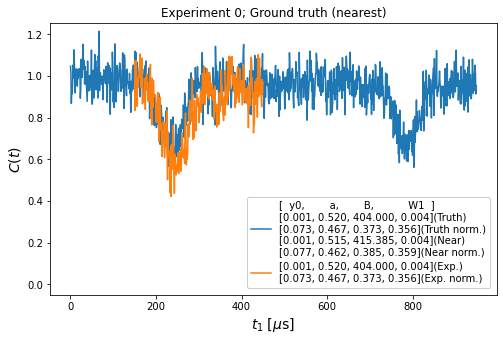

Saved in 'img/truth-0.pdf'


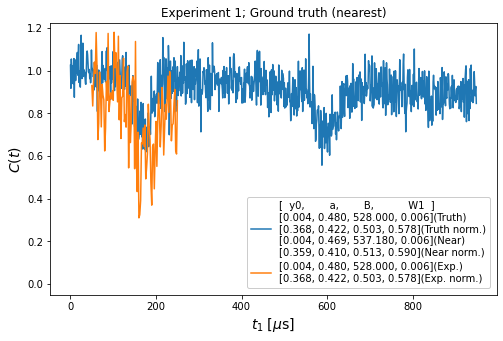

Saved in 'img/truth-1.pdf'


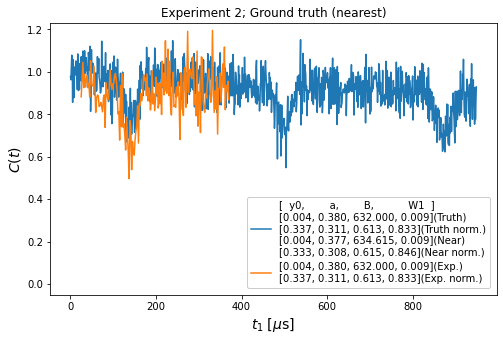

Saved in 'img/truth-2.pdf'


In [8]:
for p in range(len(parsN)):
    plotValues(pars[p], parsN[p], extraPlot=[cohs[p], pars[p], parsN[p]], title="Experiment {}; Ground truth (nearest)".format(p), save="truth-{}.pdf".format(p))

# Plot predictions

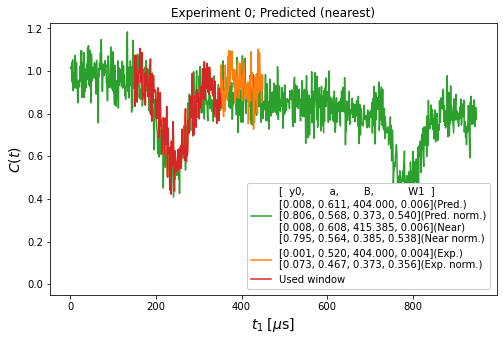

Saved in 'img/predicted-0.pdf'


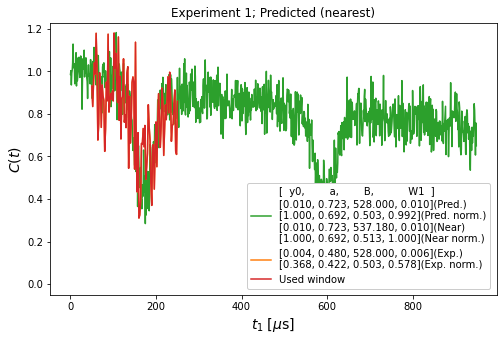

Saved in 'img/predicted-1.pdf'


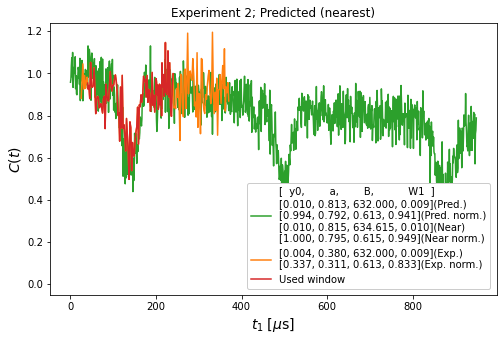

Saved in 'img/predicted-2.pdf'


In [9]:
i = 0
for i,(preds,predsN) in enumerate(zip(predictions, predictionsN)):
    plotValues([preds[0], preds[1], pars[i][2], preds[2]], [predsN[0], predsN[1], parsN[i][2], predsN[2]], extraPlot=[cohs[i], pars[i], parsN[i]], extraPlotWindow=windows[i], title="Experiment {}; Predicted (nearest)".format(i), save="predicted-{}.pdf".format(i), color='C2', labelText='Pred.')

In [10]:
def plotCoh(values, valuesN, extraPlot=None, extraPlotWindow=None, title=None, save=None, color='C0', labelText='Truth'):
    if len(values) != 4:
        raise Exception("Wrong length")

    fig = plt.figure(figsize=(8,5))

    completeValues = list(values)
    completeValues.append(8)
    coh,_ = createSingleChi(completeValues)
    plt.plot(coh, label="[  y0,        a,        B,           W1  ]\n[{:.3f}, {:.3f}, {:.3f}, {:.3f}]({})\n[{:.3f}, {:.3f}, {:.3f}, {:.3f}]({} norm.)".format(*values, labelText, *valuesN, labelText), color=color)
    if not extraPlot is None:
        # plt.plot(extraPlot[0], label="[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Exp.)\n[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Exp. norm.)".format(*extraPlot[1], *extraPlot[2]), color='C1')
        notZero = np.argwhere(extraPlot[0] != 0)
        firstNotZero = notZero[0][0]
        plt.plot(notZero, extraPlot[0][notZero], label="[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Exp.)\n[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Exp. norm.)".format(*extraPlot[1], *extraPlot[2]), color='C1')
        if not extraPlotWindow is None:
            # plt.plot(np.concatenate(notZero[0:extraPlotWindow[0]], notZero[extraPlotWindow[1]:-1]), np.concatenate(extraPlot[0][notZero[0:extraPlotWindow[0]]], extraPlot[0][notZero[extraPlotWindow[1]:-1]]), label="[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Exp.)\n[{:.3f}, {:.3f}, {:.3f}, {:.3f}](Exp. norm.)".format(*extraPlot[1], *extraPlot[2]), color='C1')
            plt.plot(range(firstNotZero+extraPlotWindow[0], firstNotZero+extraPlotWindow[1]), extraPlot[0][firstNotZero+extraPlotWindow[0]:firstNotZero+extraPlotWindow[1]], label="Used window", color='C3')


    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.legend(bbox_to_anchor=(0.43, 0.3 if extraPlotWindow is None else 0.35), loc='upper left', ncol=1, framealpha=1)
    plt.xlabel(r'$t_1 \; [\mu{\rm s}]$',fontsize=14)
    plt.ylabel(r'$C(t)$',fontsize=14)
    plt.ylim(bottom=-0.05)
    if not title is None:
        plt.title(title)
    plt.show()

    if not save is None:
        os.makedirs("img", exist_ok=True)
        fig.savefig('img/{}'.format(save), bbox_inches = 'tight')#, pad_inches = 0)
        print("Saved in 'img/{}'".format(save))


# Plot noise model exact

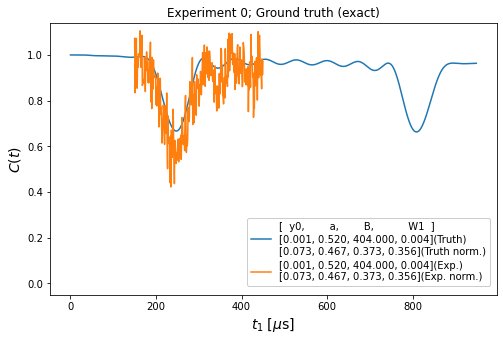

Saved in 'img/truthExact-0.pdf'


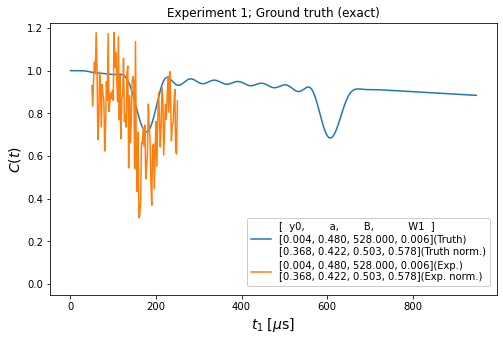

Saved in 'img/truthExact-1.pdf'


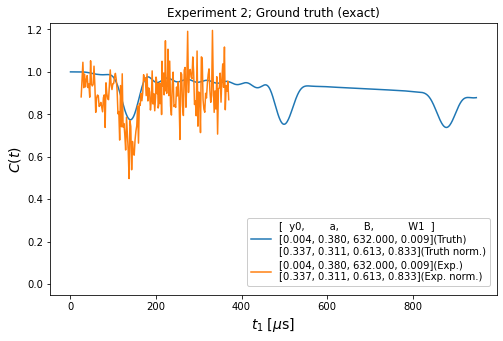

Saved in 'img/truthExact-2.pdf'


In [11]:
for p in range(len(pars)):
    plotCoh(pars[p], parsN[p], extraPlot=[cohs[p], pars[p], parsN[p]], title="Experiment {}; Ground truth (exact)".format(p), save="truthExact-{}.pdf".format(p))

# Plot predictions exact

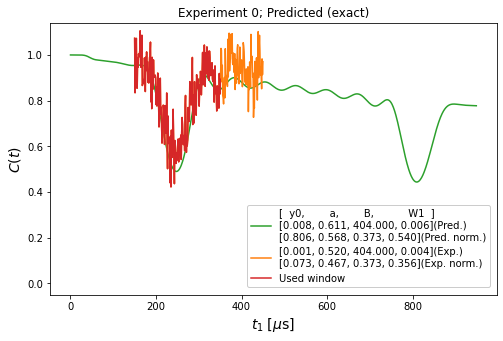

Saved in 'img/predictedExact-0.pdf'


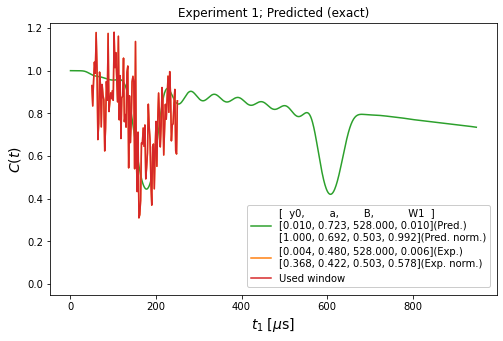

Saved in 'img/predictedExact-1.pdf'


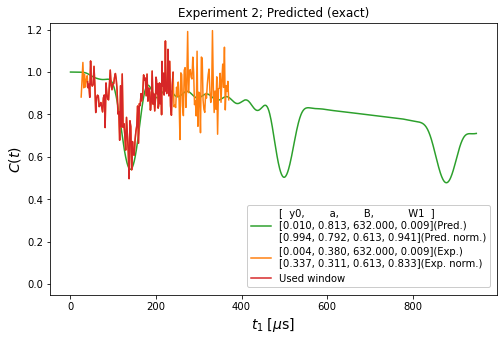

Saved in 'img/predictedExact-2.pdf'


In [12]:
i = 0
for i in range(len(predictions)):
    preds = predictions[i]
    predsN = predictionsN[i]
    plotCoh([preds[0], preds[1], pars[i][2], preds[2]], [predsN[0], predsN[1], parsN[i][2], predsN[2]], extraPlot=[cohs[i], pars[i], parsN[i]], extraPlotWindow=windows[i], title="Experiment {}; Predicted (exact)".format(i), save="predictedExact-{}.pdf".format(i), color='C2', labelText='Pred.')

